# Проект - Основы Машинного обучения

### Описание проекта

#### Постановка задачи

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. Задача — провести анализ и подготовить план действий по удержанию клиентов.

#### Последовательность выполнения шагов

* Загрузка данных, их изучение и подготовка к дальнейшему анализу
* Проведение исследовательского анализа данных (изучение признаков, их средних значений, построение гистограмм и распределений по значениям признаков для тех, кто ушел и остался в сервисе, построение матрицы корреляций)
* Построение модели прогнозирования оттока клиентов (создание бинарной классификации по целевому признаку оттока клиента в следующем месяце, применение моделей логистической регрессии и случайного леса, оценка метрик accuracy, precision и recall и выбор лучшей модели)
* Кластеризация клиентов (стандартизация данных, построение матрицы расстояний и обучение модели K-Means, создание прогнозов на основе модели, анализ полученных значений)
* Формулировка основных выводов и рекомендация по проекту

#### Описание данных

«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:


**Данные клиента за предыдущий до проверки факта оттока месяц:**


* `gender` — пол;
* `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
* `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
* `Phone` — наличие контактного телефона;
* `Age` — возраст;
* `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).


**Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:**


* `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
* `Group_visits` — факт посещения групповых занятий;
* `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
* `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
* `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
* `Churn` — факт оттока в текущем месяце.

## Загрузка данных и подготовка их к анализу

### Загрузка и обзор данных

In [1]:
#Импорт библиотек
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import display
import warnings
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans
from itertools import combinations
from sklearn.metrics import silhouette_score

# отключение уведомлений об ошибке при замене исходного набора данных
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

# показ всех колонок датафрейма
pd.options.display.max_columns = None

In [2]:
# загружаем файл в переменную и выводим на экран первые 5 строк
gym_churn = pd.read_csv('D:/Datasets/gym_churn.csv')

gym_churn.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Посмотрим данные поподробнее

In [3]:
gym_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


**Выводы**

Пропусков в данных не обнаружено

### Предобработка данных

#### Приведение столбцов к нижнему регистру

In [4]:
gym_churn.columns = gym_churn.columns.str.lower()

#### Обработка дубликатов

In [5]:
print('Количество дубликатов в таблице:', gym_churn.duplicated().sum())

Количество дубликатов в таблице: 0


**Выводы**

Дубликатов в таблице не обнаружено

#### Удаление выбросов

Удалим выбросы в колонках  `age, avg_additional_charges_total, lifetime, avg_class_frequency_total`. Верхней и нижней границей будут 99 и 1 перцентили по соответственному столбцу.

In [6]:
#готовим колонки для обработки и фильтруем значения каждой в цикле 
columns_to_prep = ['age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total']
for column in columns_to_prep:
    max_value = int(np.percentile(gym_churn[column], [99]))
    min_value = int(np.percentile(gym_churn[column], [1]))
    gym_churn = gym_churn.query(f'@min_value <= {column} <= @max_value')

## Исследовательский анализ данных 

### Описание средних значений и отклонений для признаков

Опишем данные методом `describe()`

In [7]:
gym_churn.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
gender,3793.0,0.51,0.50,0.00,0.00,1.00,1.00,1.00
near_location,3793.0,0.84,0.36,0.00,1.00,1.00,1.00,1.00
partner,3793.0,0.49,0.50,0.00,0.00,0.00,1.00,1.00
promo_friends,3793.0,0.31,0.46,0.00,0.00,0.00,1.00,1.00
phone,3793.0,0.90,0.30,0.00,1.00,1.00,1.00,1.00
contract_period,3793.0,4.66,4.55,1.00,1.00,1.00,6.00,12.00
group_visits,3793.0,0.40,0.49,0.00,0.00,0.00,1.00,1.00
age,3793.0,29.17,3.17,21.00,27.00,29.00,31.00,37.00
avg_additional_charges_total,3793.0,144.45,91.18,2.03,69.32,135.23,208.43,400.99
month_to_end_contract,3793.0,4.31,4.20,1.00,1.00,1.00,6.00,12.00


**Выводы**

* Практически все члены фитнес-центра проживают или работают в одном районе с клубом (84%).
* Каждый второй участник клуба является сотрудником компании парнёра-клуба, то есть получает скидки на абонемент.
* Каждый третий член клуба воспользовался акцией "Приведи друга".
* Практически все пользователи оставляют контактные телефон (90%).
* В среднем длительность контракта составляет около 5 месяцев. Среднее отклонение находится на уровне в 4,5 месяца, что может говорит о том, что часто покупают как длительные абонементы, так и кратковременные (всего на месяц).
* Около 40% посетителей клуба ходят на групповые занятия.
* Средний возраст составляет 29 лет, а среднее отклонение всего 3 года. Максимальные возраст участника клуба - 37 лет.
* Дополнительные средние траты в месяц составляют в районе 150 единиц, отклонение по данному признаку довольно высокое - 91 единиц. То есть имеются и те, кто практически ничего не покупает, и те, кто любит воспользоваться дополнительными услугами
* Время с первого обращения в фитнес-клуб составляет в среднем около 4 месяцев. Так же наблюдается значительное среднее отклонение в 4 месяца.
* Недельная посещаемость в среднем составляет 2 дня со средним отклонением в 1 день. 
* Отток пользователей в среднем за текущий месяц составляет 27%. То есть клуб потеряет практически треть участников в этом месяце!

### Средние значения признаков по группам

In [8]:
gym_churn.groupby('churn').mean().round(2)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.51,0.87,0.54,0.36,0.9,5.76,0.46,29.96,155.20,5.30,4.52,1.97,1.97
1,0.51,0.77,0.35,0.18,0.9,1.73,0.27,27.07,115.81,1.66,0.98,1.48,1.05


**Выводы**

Больше всего между группами тех, кто остался и тех, кто ушёл различаются признаки:
* `contract_period` (5.76 и 1.73) 
* `avg_additional_charges_total` (155 и 116)
* `month_to_end_contract` (5.30 и 1.66)
* `lifetime` (4.52 и 0.98) 
* `avg_class_frequency_current_month` (1.97 и 1.05)

### Распределение признаков по группам

Построим графики распределения признаков для ушедших и оставшихся клиентов

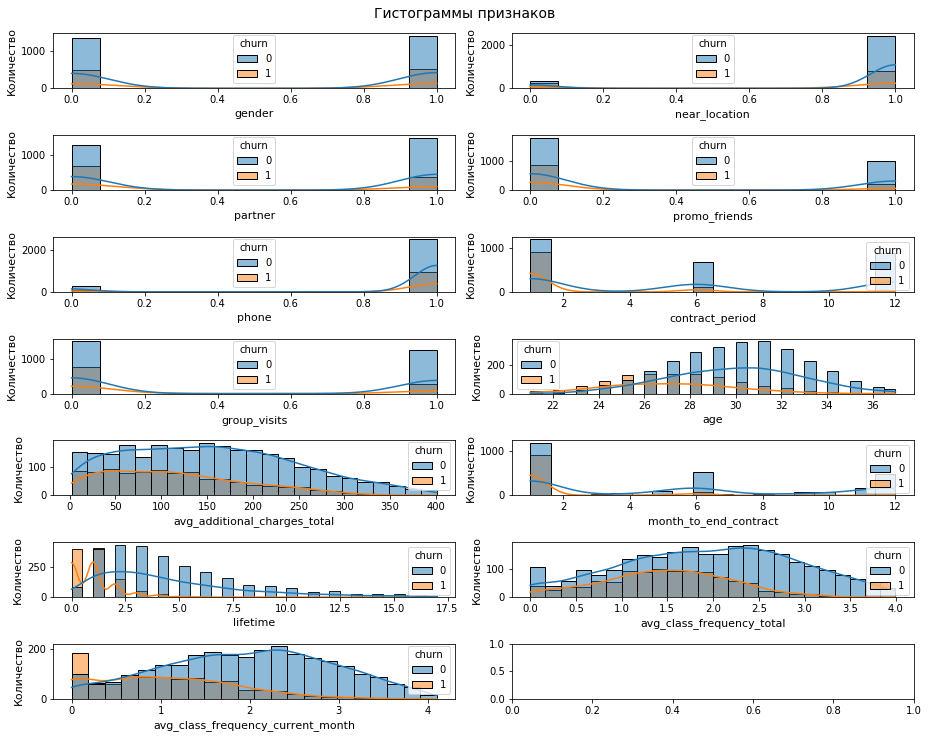

In [9]:
#выделяем признаки
fig, axs = plt.subplots(7, 2, figsize=(13, 10))
fig.suptitle('Гистограммы признаков', size=14, y=1.02)


features = gym_churn.drop(columns='churn').columns.to_list()

for feature, ax in zip(features, np.ravel(axs)):
    sns.histplot(data = gym_churn, x=feature, hue='churn', ax=ax, kde=True)
    ax.set_ylabel('Количество', fontsize = 11)
    ax.set_xlabel(feature, fontsize = 11)
    
    
plt.tight_layout()

**Выводы**

* Ушедшие клиенты реже были сотрудниками компании-партнёра клуба, а также значительно реже пользовались акцией "приведи друга"
* Огромное количество ушедших клиентов имели остаток по контракту в 1 месяц, значительно меньше в 6 месяцев, и практически не было тех, у кого был остаток в 12 месяцев
* В основном ушедшими клиентами были люди в более молодом возрасте (20-27 лет), после 27 лет доля ушедших клиентов от всех клиентов начинает снижаться. После 35 лет их доля практически равна 0
* Ушедшие клиенты реже тратили деньги на дополнительные услуги
* Подавляющее количество ушедших членов клуба впервые обращались в фитнес клуб за 1-2 месяца до своего ухода. Проводя связь с другими графиками можно сделать предположение, что такие клиенты обращались в клуб, оформляли абонемент, тренировались 1-2 месяца, а затем прекращали.
* Графики посещения клуба подтверждают, что посещаемость ушедших клиентов была ниже, чем у оставшихся.
* Есть огромное количество ушедших клиентов, которые за последний месяц не посещали фитнес-центр в принципе, так же велика доля тех, кто посещал клуб всего раз в неделю (для сравнения оставшиеся клиенты в среднем посещали клуб трижды в неделю)

### Матрица корреляций

Построим матрицу корреляций для всех признаков

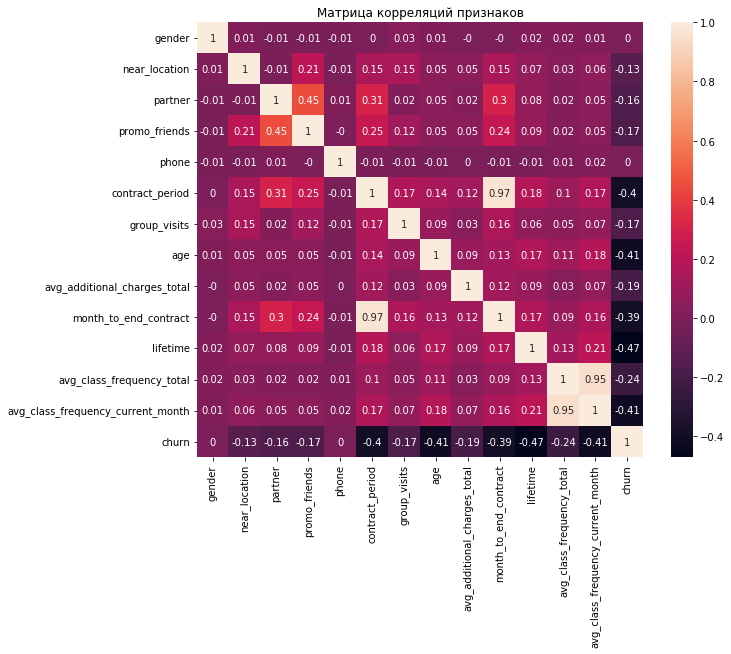

In [10]:
#строим матрицу корреляций и отрисовываем через heatmap
cm = gym_churn.corr().round(2) 

fig, ax = plt.subplots(figsize=(10,8))        
sns.heatmap(cm, annot=True, ax=ax)
plt.title('Матрица корреляций признаков')

plt.show()

**Выводы**

* Признаки `contract_period` и `month_to_end_contract` очень коррелируют (0.97), оно и неудивительно, ведь признаки обозначают практически одно и то же. Так же сильно коррелируют признаки `avg_class_frequency_total` и `avg_class_frequency_current_month` (0.95). Удалим из датасета один из них, чтобы не возникло в дальнейшем проблем с обучением моделей.
* Незначительно коррелируют между собой признаки `promo_friends` и `partner` (0.45), `churn` и `age` (-0.41), `churn` и `avg_class_frequency_current_month` (-0.41), `churn` и `lifetime` (-0.47), `churn` и `contract_period` (-0.4)

In [11]:
# удаление столбцов, сильно коррелирующих с другими
gym_churn = gym_churn.drop(columns=['contract_period', 'avg_class_frequency_current_month'])

## Модель прогнозирования оттока клиентов

### Разбиение выборки на обучающую и валидационную

Разделим данные на признаки и целевую переменную, создадим две выборки, а затем стандартизируем данные

In [12]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = gym_churn.drop(columns='churn')
y = gym_churn['churn']

#разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#проверим, правильно ли разбились обучающая и валидационная выборки
print('Размер изначальных выборок: X - {} и y - {}'.format(len(X), len(y)))
print(
    '''Размер обучающих выборок и их доля от изначальной выборки: X - {}, {} и y - {}, {}'''
       .format(len(X_train), round(len(X_train) / len(X), 2), (len(y_train)), round(len(y_train) / len(y), 2)))
print(
    '''Размер валидационных выборок и их доля от изначальной выборки: X - {}, {} и y - {}, {}'''
       .format(len(X_test), round(len(X_test) / len(X), 2), (len(y_test)), round(len(y_test) / len(y), 2)))

Размер изначальных выборок: X - 3793 и y - 3793
Размер обучающих выборок и их доля от изначальной выборки: X - 3034, 0.8 и y - 3034, 0.8
Размер валидационных выборок и их доля от изначальной выборки: X - 759, 0.2 и y - 759, 0.2


**Вывод**

Выборки разбили, проверка подтвердила правильность разбиения 80 на 20

Теперь стандартизируем выборки

In [13]:
# создадим объект класса StandardScaler и применим его к обучающей выборке
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train) # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

### Обучение моделей и сравнение метрик

Посмотрим количество ушедших и оставшихся пользователей

In [14]:
gym_churn['churn'].value_counts()

0    2758
1    1035
Name: churn, dtype: int64

**Выводы**

Распределение клиентов по группам неравномерно, примерно 70 на 30, ушедших клиентов меньшинство

In [15]:
# модели для будущего использования
models_prediction = [LogisticRegression, DecisionTreeClassifier]

Создадим функцию для обучения модели, получения предсказаний по ней и оценки метрик `accuracy, precision и recall`

In [16]:
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m(random_state=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy: {:.2f} Precision: {:.2f} Recall: {:.2f}'.format(
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred)))

for i in models_prediction:
    print(i)
    make_prediction(i, X_train_st, y_train, X_test_st, y_test)

<class 'sklearn.linear_model.logistic.LogisticRegression'>
Accuracy: 0.89 Precision: 0.77 Recall: 0.80
<class 'sklearn.tree.tree.DecisionTreeClassifier'>
Accuracy: 0.83 Precision: 0.65 Recall: 0.70


**Выводы**

* Метрика `Accuracy` между моделями различается незначительно (0.89 для логистической регрессии и 0.83 для дерева принятия решений). Важно отметить, что данная метрика в нашем случае не совсем верно отражает картину, ведь разбивка целевой переменной (churn) не 50 на 50, а скорее 70 на 30 (ушедших клиентов меньше), поэтому оценивать качество моделей будем по двум другим метрикам
* Метрики `Precision` и `Recall` для моделей составляют соответственно 0.77 и 0.80 для логистической регрессии, 0.65 и 0.70 для дерева принятия решений. Можем сделать вывод, что модель логистической регрессии лучше предсказывает отток клиентов (примерно на 10%, чем модель дерева)

### Важность признаков

На примере лучшей модели (дерево принятия решений) узнаем, какие из признаков наиболее сильно влияют на отток клиентов

In [17]:
final_model = DecisionTreeClassifier()
final_model.fit(X_train_st, y_train)
y_pred = final_model.predict(X_test_st)

# создадим датафрейм с именами признаков и их важностью, выведем его по убыванию важности признака
importances = pd.DataFrame({'Признак': X.columns, 'Важность': final_model.feature_importances_.round(2)})
print(importances.sort_values(by='Важность', ascending=False))

                         Признак  Важность
9                       lifetime      0.38
10     avg_class_frequency_total      0.14
6                            age      0.13
7   avg_additional_charges_total      0.13
8          month_to_end_contract      0.13
0                         gender      0.02
2                        partner      0.02
4                          phone      0.02
5                   group_visits      0.02
1                  near_location      0.01
3                  promo_friends      0.01


**Выводы**

Наиболее значимым признаком, влияющим на отток клиентов, стал признак `lifetime`, его важность равна (0.38), затем идут признаки `avg_class_frequency_total` (0.15), age и avg_additional_charges_total (0.14), month_to_end_contract (0.13). Остальные признаки практически не влияют на отток клиентов

## Кластеризация клиентов

### Построение матрицы расстояний

Построим матрицу расстояний, а затем с её помощью и дендрограмму по признакам, наиболее сильно влияющим на отток клиентов

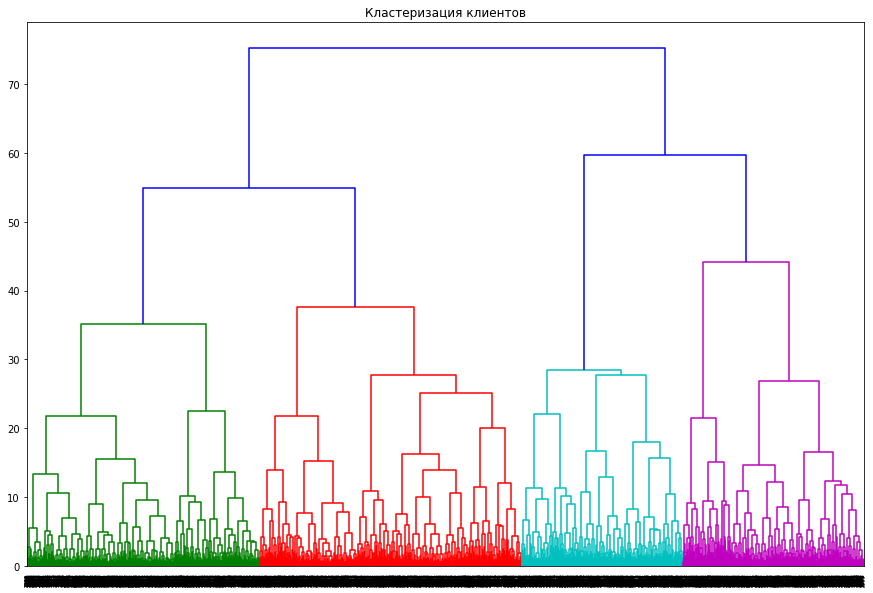

In [18]:
# Основные признаки, сильнее всего влияющие на отток клиентов
main_features = X.drop(columns=['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits'])

# Стандартизируем данные
X_sc = scaler.fit_transform(main_features)
linked = linkage(X_sc, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация клиентов')
plt.show() 

**Выводы**

Предложенное оптимальное количество кластеров равно 4. Предполагаю, что выделились группы надежных и ненадежных клиентов

### Модель кластеризации K-Means

Будем строить модель K-Means с числом кластеров, равных 4, так как именно это число кластеров было отрисовано дендрограммой

Зададим модель K-Means

In [19]:
# задаём модель k_means с числом кластеров 4 и фиксируем значение random_state
km = KMeans(n_clusters=4, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 4)
labels = km.fit_predict(X_sc)

#задаём датасет, в который будем сохранять метки кластера
features_cluster = gym_churn.drop(columns=['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits'])
# сохраняем метки кластера в поле датасета
features_cluster['cluster_km'] = labels

              age  avg_additional_charges_total  month_to_end_contract  \
cluster_km                                                               
0           29.81                        180.42                  10.42   
1           29.61                        151.77                   4.34   
2           26.54                        122.74                   1.94   
3           31.38                        137.71                   2.20   

            lifetime  avg_class_frequency_total  churn  
cluster_km                                              
0               3.58                       1.96   0.03  
1              10.51                       2.00   0.00  
2               1.64                       1.35   0.64  
3               2.91                       2.21   0.17  


Создадим функцию для отрисовки графиков попарных признаков для кластеров

In [20]:
def show_clusters_on_plot(df, x_name, y_name, cluster_name):

    plt.figure(figsize=(5, 5))
    sns.scatterplot(
        df[x_name], df[y_name], hue=df[cluster_name], palette='Paired'
    )
    plt.title('{} vs {}'.format(x_name, y_name))
    plt.show()

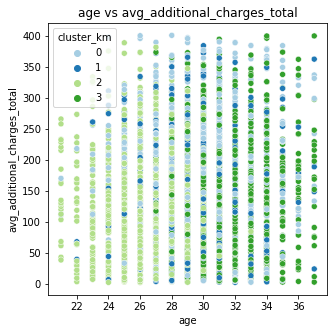

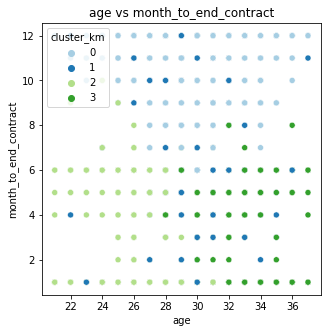

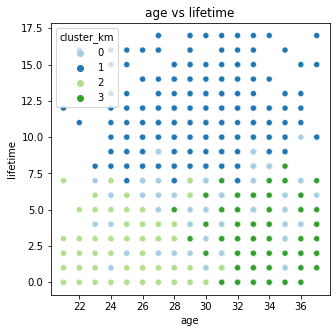

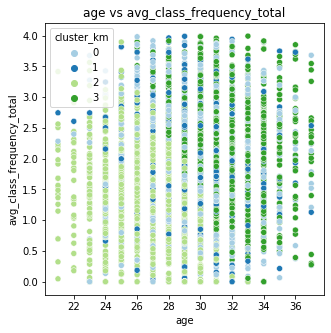

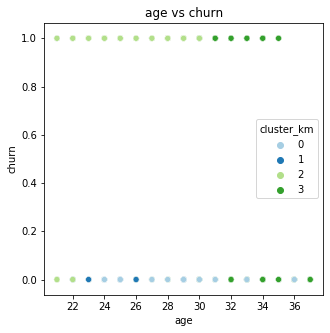

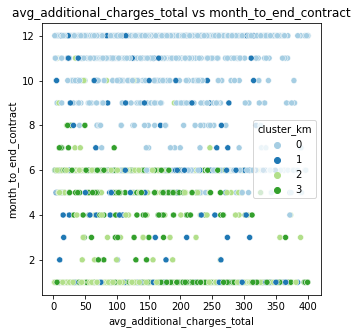

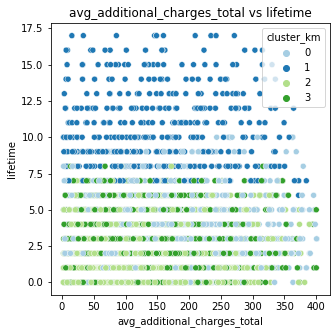

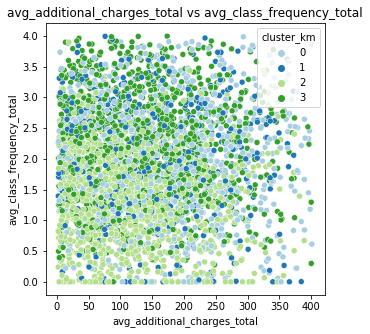

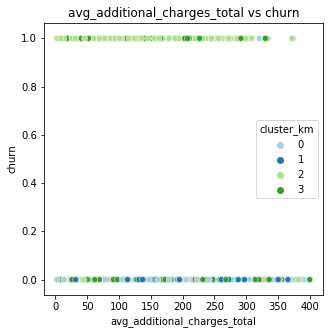

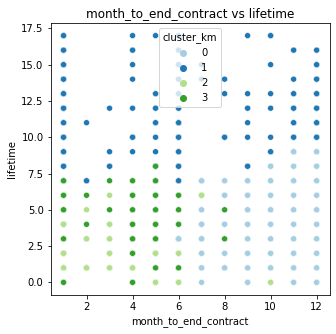

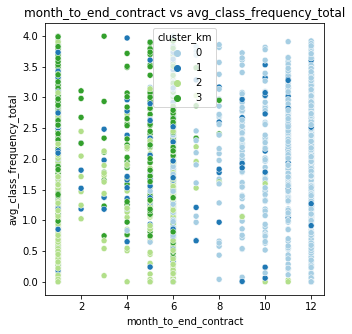

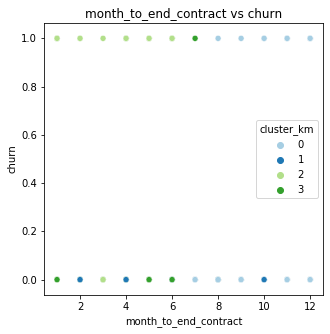

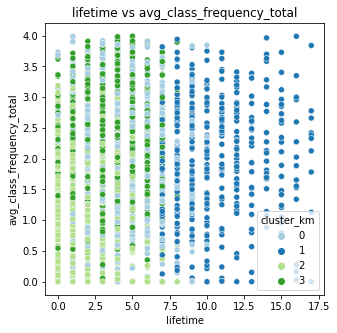

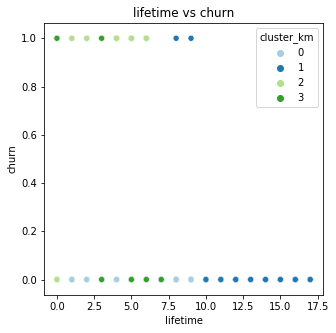

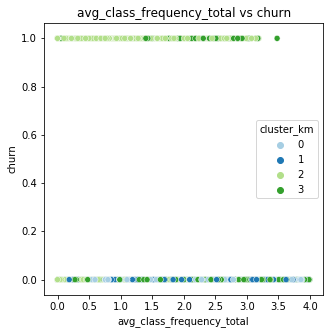

In [21]:
# отрисуем графики для попарных сочетаний признаков с разметкой по кластерам

col_pairs = list(combinations(features_cluster.drop('cluster_km', axis=1).columns, 2))
for pair in col_pairs:
    show_clusters_on_plot(features_cluster, pair[0], pair[1], 'cluster_km')

Дополнительно рассчитаем количество клиентов в разных кластерах

In [22]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))

{0: 893, 1: 457, 2: 1270, 3: 1173}

In [23]:
# выводим статистику по средним значениям наших признаков по кластеру
print(features_cluster.groupby('cluster_km').agg('mean').round(2))

              age  avg_additional_charges_total  month_to_end_contract  \
cluster_km                                                               
0           29.81                        180.42                  10.42   
1           29.61                        151.77                   4.34   
2           26.54                        122.74                   1.94   
3           31.38                        137.71                   2.20   

            lifetime  avg_class_frequency_total  churn  
cluster_km                                              
0               3.58                       1.96   0.03  
1              10.51                       2.00   0.00  
2               1.64                       1.35   0.64  
3               2.91                       2.21   0.17  


**Выводы**

Мы разделили клиентов на 4 кластера:
* Наиболее надежные клиенты попали в 0 и 1 кластеры, менее надежные клиенты в 3 кластер, наименее надежные во 2 кластер (если смотреть по среднем оттоку)
* Наиболее надежные клиенты имеют средний возраст около 30 лет, процент оттока этих клиентов близится к 0. Среди них есть разделение: 0 кластер - те, кто тратят на дополнителньые услуги больше среднего (180 единиц при среднем в 155), имеют длительный контракт (срок до окончания более 10 месяцев), впервые обращались в фитнес-центр чуть более 3 месяцев назад, а также посещают клуб в среднем 2 раза в неделю. В первом кластере ситуация другая, клиенты тратят на дополнителньые услуги суммы, близкие к средним, имеют контракт средней длительности (около 4 месяцев до окончания), при этом впервые обращались в фитнес-центр они достаточно давно (около 11 месяцев назад, уже успели стать постоянными постоянными), посещают клуб в среднем около 2 раз в неделю. 
* Менее надежные клиенты из 3 кластера в среднем покидают клуб с вероятностью в `17%`. Средний возраст 31 год, тратят на дополнительные услуги меньше среднего (138 единиц при среднем в 155), длительность оставшегося абонемента у них чуть больше 2 месяцев, впервые обращались в клуб около 3 месяцев назад и посещают клуб в среднем дважды в неделю
* Наименее надежные клиенты из 2 кластера уходят с вероятностью в `64%`. Средний возраст 27 лет, тратят в среднем на дополнительные услуги всего 123 единицы,  не имеют длительного контракта (срок до окончания менее 2 месяцев), впервые обращались в фитнес-центр примерно полтора месяца назад, а также посещают клуб реже 3 раз в 2 недели
* Количество клиентов (их процент от всех клиентов) из разных кластеров составляет: 0 - 893 (24%), 1 - 457 (12%), 2 - 1268 (33%), 3 - 1175 (31%). То есть к группе самых надежных клиентов принадлежит более трети `(36%)` от всех клиентов

## Выводы и рекомендации по проекту

**Основные выводы**
1. Была создана модель для предсказания оттока клиентов по их признакам. Модель дерева принятия решений показала себя наиболее точной, она давала правильный прогноз практически в 80% случаев.
2. Были сформированы типичные портреты клиентов по их признакам. По дендрограмме мы оценили, что выделяются 4 кластера пользователей, ненадежные и надежные (постоянные клиенты и новые), а также клиенты средней надежности. 
3. БОльшая часть клиентов фитнес-центра являются достаточно надежными, 36% из них практически никогда не отказываются от абонементов, ещё 31% покидают клуб достаточно редко (всего в 17% случаях). Однако, среди клиентов присутствует 33% тех, кто могут покинуть клуб с большой вероятностью (64%).
4. Чтобы понять, к какой группе относится клиент и оценить вероятность его ухода, необходимо внимательно посмотреть на несколько признаков:
    * `lifetime` - если клиент впервые обращался в клуб менее 2 месяцев назад и у него кратковременный абонемент (месяц или несколько месяцев), то высока вероятность его оттока. Если обращался давно (больше 3 месяцев назад), а абонемент у него надолго (более 4 месяцев), то он с большой долей вероятности будет с радостью тренироваться и дальше
    * `age` - у клиентов в более молодом возрасте (до 27 лет) вероятность покинуть клуб выше, чем у тех, кто старше 27
    * `avg_class_frequency_total` - если клиент ходит в фитнес-клуб реже, чем дважды в неделю, то вероятность его ухода возрастает
    * `avg_additional_charges_total` - у тех, кто тратит на дополнительные услуги в клубе меньше среднего, повышается вероятность оттока
    * `month_to_end_contract` - чем длиннее контракт у клиента, тем более надежным он является
    

**Основные рекомендации**

1. Чтобы определить уйдет ли клиент или нет, прежде всего, стоит смотреть на то, как давно клиент впервые обращался в клуб и на сколько месяцев он купил абонемент, как часто он посещает фитнес-клуб и сколько тратит средств на дополнительные услуги. В зависимости от сочетания данных признаков можно вычислить, к какой группе можно отнести этого клиента, и соответственно вычислить вероятность его оттока. Так же можно использовать разработанную мною модель для предсказания ухода клиента)
2. В зависомости от того, к какой группе принадлежит клиент, можно разработать подход к каждой группе:
    * Группа надежных клиентов - их устраивают оказываемые нами услуги, продолжаем в том же духе!
    * Группа средне-надежных клиентов - есть аспекты, которые их не устраивают. Возможно, стоит проводить опрос каждый раз, как клиент из этой группы разрывает контракт или резко перестаёт посещать клуб при активном абонементе. Таким образом, мы сможем узнать, что стоит улучшить для предотвращения оттока клиентов этой группы
    * Группа ненадежных клиентов - в основном это люди, которые покупали абонементы на короткий срок, после истечения которого переставали посещать фитнес-клуб.  Стоит придумать, как их удержать. Как вариант - так же опрашивать их, что они хотели бы видеть в клубе, возможно, дополнительные групповые тренировки, йогу или различные тренировки по боевым искусствам. Таким образом добавлять те услуги, которые их заинтересуют.